#Table of Contents
* [1. Fitting a local equilibrium model to foam scan data](#1.-Fitting-a-local-equilibrium-model-to-foam-scan-data)
	* [1.1 Relative permeability curves](#1.1-Relative-permeability-curves)
	* [1.2 Visualize RelPerms](#1.2-Visualize-RelPerms)
	* [1.3 Read the data file](#1.3-Read-the-data-file)
	* [1.4 Assign values to the physical parameters](#1.4-Assign-values-to-the-physical-parameters)
	* [1.5 Experimental data](#1.5-Experimental-data)
	* [1.6 Define the foam model](#1.6-Define-the-foam-model)
	* [1.7 Calculate the liquid saturation for data points](#1.7-Calculate-the-liquid-saturation-for-data-points)
	* [1.8 Calculate the experimental foam parameters](#1.8-Calculate-the-experimental-foam-parameters)
	* [1.9 Create the variables](#1.9-Create-the-variables)
	* [1.10 Create and solve a JuMP model: three parameters](#1.10-Create-and-solve-a-JuMP-model:-three-parameters)
	* [1.11 Visualize three parameter results](#1.11-Visualize-three-parameter-results)
	* [1.12 Create and solve a JuMP model: five parameters](#1.12-Create-and-solve-a-JuMP-model:-five-parameters)
	* [1.13 Visualize the results](#1.13-Visualize-the-results)


# 1. Fitting a local equilibrium model to foam scan data

This notebook explains how mathematical programming can be used to optimize the parameters of an implicit function. Here, I will use `Julia` language and the package `JuMP`.

In [1]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames
PyPlot.rc("font", family="sans")

INFO: Loading help data...


## 1.1 Relative permeability curves

In [2]:
# Relperm data
swc = 0.10
sgr = 0.05
krg0 = 0.94
ng = 1.8
krw0 = 0.22
nw = 4.0
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0))

krw (generic function with 1 method)

## 1.2 Visualize RelPerms

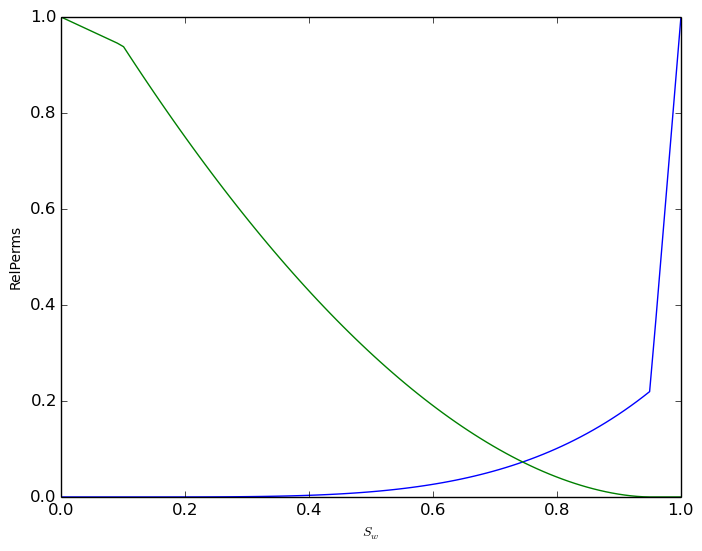

PyObject <matplotlib.text.Text object at 0x7fd69e96bc50>

In [3]:
sw_plot = linspace(0.0,1.0, 100)
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
xlabel(L"S_w")
ylabel("RelPerms")

## 1.3 Read the data file

First, I read the data table using the `DataFrames` package.

In [4]:
data1 = readtable("AOS0.1_N2_Benth_CT_mu_foam.csv")

,ug,uw,mu_gas,mu_liq,muf_tot,sw_ave,muf_in,fg_in,fg_out,muf_err
1,7.22901544227256e-7,1.3961e-5,1.96983325922981e-5,0.0009523534,0.4698853834,0.2520354767,0.3978922274,0.0481171905,0.0481171905,0.0487195252
2,1.44428267487965e-6,1.32261725561132e-5,1.97013045315612e-5,0.0009523514,0.5468685359,0.2313416826,0.4776860747,0.096001498,0.096001498,0.0490245169
3,2.87364621601587e-6,1.17565978276562e-5,1.9716e-5,0.0009523414,0.6789611951,NaN,0.6088694633,0.1910760668,0.1910760668,0.0259167307
4,4.2788135928734e-6,1.0287e-5,1.97371246581159e-5,0.0009523271,0.7910268832,0.2228990002,0.7171538139,0.285683052,0.285683052,0.0298682106
5,5.6842006471532e-6,8.81744837074212e-6,1.97477238244481e-5,0.0009523199,0.8699522844,NaN,0.7858203623,0.3818400879,0.3818400879,0.0296489398
6,7.002e-6,7.3478736422851e-6,1.97906382693141e-5,0.0009522911,1.0230186268,0.2240661625,0.9239163393,0.4757842396,0.4757842396,0.0306088327
7,8.33566311217759e-6,5.87829891382808e-6,1.98144180778032e-5,0.0009522753,1.2144808499,0.2265786361,1.0851998443,0.5726673992,0.5726673992,0.0230287343
8,9.0518088977227e-6,5.14351154959957e-6,1.98072918249579e-5,0.00095228,1.2827716619,NaN,1.1488310581,0.6237609767,0.6237609767,0.0195599558
9,9.5977611710932e-6,4.40872418537106e-6,1.98566956977427e-5,0.0009522473,1.3703433884,0.2153505832,1.199228193,0.6717795974,0.6717795974,0.0623433014
10,1.0332e-5,3.67393682114255e-6,1.98399051528417e-5,0.0009522584,1.46517932,0.2157277584,1.2435177984,0.7246767452,0.7246767452,0.0361701537


## 1.4 Assign values to the physical parameters

In [5]:
# Viscosity data [Pa.s]
muw = float(data1[:mu_liq])
mug = float(data1[:mu_gas])
# IFT value [N/m]
sigma_wg = 0.03;

## 1.5 Experimental data

In [6]:
# Foam quality
ug = float(data1[:ug]) # [m/s]
uw = float(data1[:uw]) # [m/s]
u = ug+uw # [m/s]
fg_exp = ug./u # [-]
# Foam apparent viscosity [Pa.s]
muf_exp = float(data1[:muf_tot]) # [Pa.s]
sw_ct= float(data1[:sw_ave])
n_data = length(ug)
println("Data is loaded.")

Data is loaded.


## 1.6 Define the foam model

In [7]:
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2)=(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 1 method)

## 1.7 Calculate the liquid saturation for data points

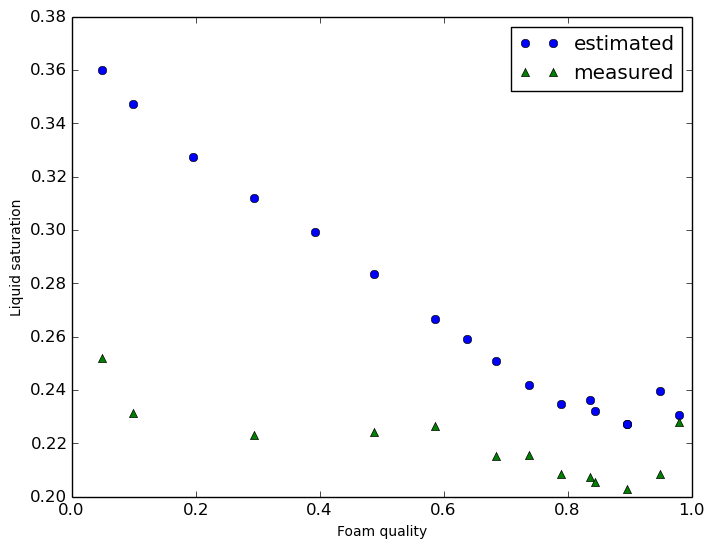

17-element Array{Float64,1}:
 0.360036
 0.347053
 0.327409
 0.311934
 0.29935 
 0.283385
 0.266548
 0.258945
 0.250935
 0.241819
 0.234654
 0.236365
 0.232154
 0.227241
 0.227045
 0.239605
 0.230406

In [8]:
sw_exp = (1-swc-sgr)*(muw.*(1-fg_exp)./(krw0*muf_exp)).^(1/nw)+swc
plot(fg_exp, sw_exp, "o")
plot(fg_exp, sw_ct, "^")
xlabel("Foam quality")
ylabel("Liquid saturation")
legend(["estimated", "measured"])
sw_exp

## 1.8 Calculate the experimental foam parameters

See our paper for more details.

In [9]:
FM = mug./muw.*fg_exp./(1-fg_exp).*(krw(sw_exp)./kr(sw_exp))
f_foam = 1./FM-1

17-element Array{Float64,1}:
 236038.0 
 142841.0 
  94097.6 
  76532.3 
  65300.8 
  64297.2 
  66347.7 
  65769.5 
  66585.7 
  67749.5 
  63640.5 
  44430.0 
  48150.4 
  35507.5 
  35678.5 
  10912.4 
   5642.68

## 1.9 Create the variables

In [10]:
m = Model(solver=IpoptSolver(print_level=1))
#m = Model()
# define the variables of the foam model
@defVar(m, 100<=fmmob<=5000000)
@defVar(m, 10<=epdry<=500000)
@defVar(m, swc<=fmdry<=swc+0.4)
@defVar(m, 1.0e-6<=fmcap<=1.0e-4)
@defVar(m, -3.0<=epcap<=4.0)

epcap

## 1.10 Create and solve a JuMP model: three parameters

In [11]:
w=ones(length(muf_exp))
ind_mu_max= indmax(muf_exp)
w[ind_mu_max-1:ind_mu_max+1]=1000
@setNLObjective(m, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi))^2, i=1:n_data})
solve(m)
# get the result
x1 = [getValue(fmmob), getValue(epdry), getValue(fmdry)]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



3-element Array{Float64,1}:
 68316.4     
  1523.43    
     0.231628

## 1.11 Visualize three parameter results

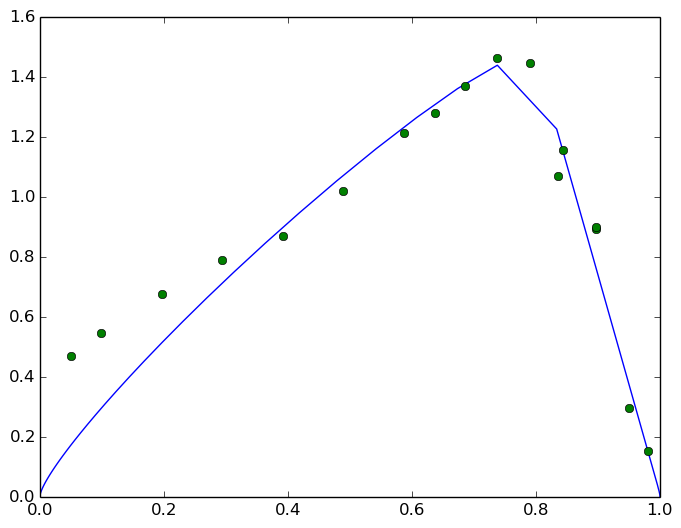

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd69b9bb110>
 PyObject <matplotlib.lines.Line2D object at 0x7fd69b9bb390>

In [12]:
sw_val = linspace(0,1.0, 100)
fg_opt = fg(sw_val, x1)
muf_opt = mu_foam(sw_val, x1)
plot(fg_opt, muf_opt, fg_exp, muf_exp, "o")

## 1.12 Create and solve a JuMP model: five parameters

In [13]:
@setNLObjective(m, Min, sum{w[i]*(f_foam[i]-
    fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
# solve it
solve(m)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
 129278.0       
   1969.33      
      0.231915  
      4.41981e-5
      0.237464  

## 1.13 Visualize the results

One method is to calculate the pressure drop in different gas and liquid rates, and plot the pressure drop contours versus gas and liquid velocity. The following result is visualized for a few average total flow rates.

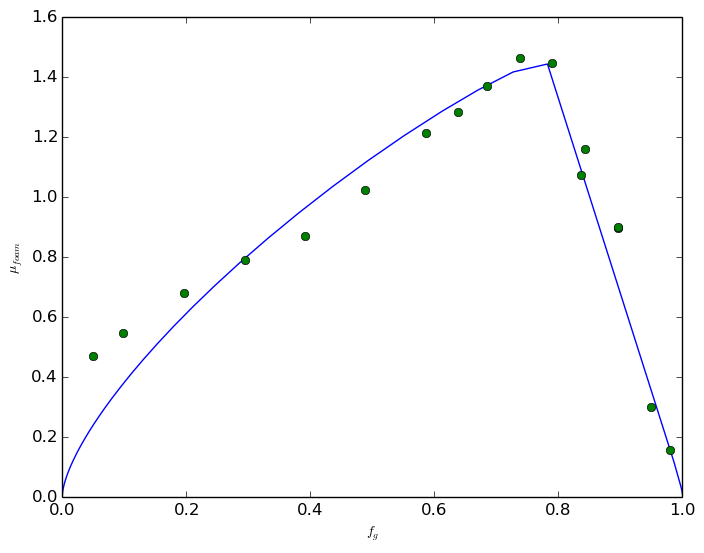

PyObject <matplotlib.text.Text object at 0x7fd69be1e2d0>

In [14]:
sw_plot = linspace(0.15,1.0, 100)
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    fmu(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    muf_opt[i]=fzero(fmu, 1.0)
end
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")

In [15]:
mu_foam2(sw_plot[1], x2[1:3], x2[4:5], 0.8, u_ave)

0.003582411439327811

# A discontinuous model

Note: $f_g$ --> 0, $\mu_{app}$ --> $\mu_{app,0}$  
The first step is to fit a curve (line, polynomial, or power law) to the low quality regime and find the $\mu_{app,0}$. Then, the new functions that are defined below will be used to fit the foam scan data.

In [16]:
# define the new model with mu_app0
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2, mu0)=mu0+(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u, mu0)=mu0+(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 2 methods)

In [17]:
# filter the low quality data for the low quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_low= find(fg_exp.<=fg_trans)
fg_low= fg_exp[ind_fg_low]
sw_low= sw_ct[ind_fg_low]
muf_low= muf_exp[ind_fg_low]
# filter the high quality data for the high quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_high= find(fg_exp.>=fg_trans)
fg_high= fg_exp[ind_fg_high]
sw_high= sw_ct[ind_fg_high]
muf_high= muf_exp[ind_fg_high]

8-element Array{Float64,1}:
 1.46518 
 1.4465  
 1.07299 
 1.15943 
 0.896267
 0.900058
 0.299594
 0.156026

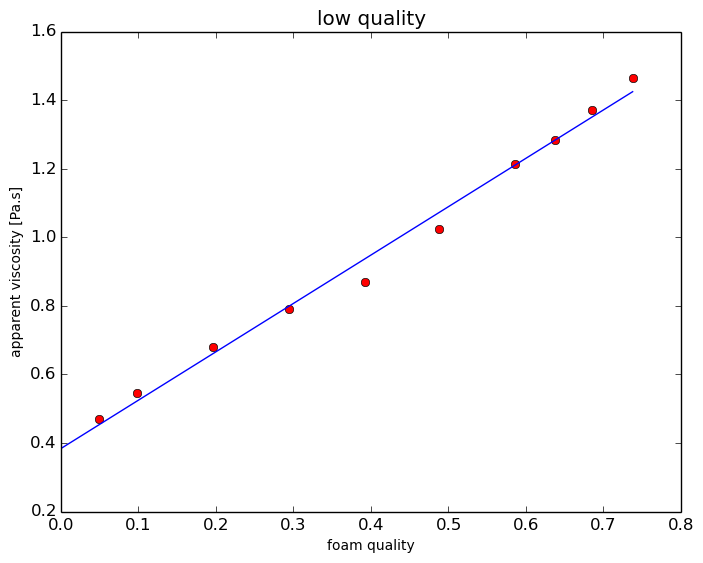

PyObject <matplotlib.text.Text object at 0x7fd69b9d0050>

In [18]:
(muf_0,dmudfg)=linreg(fg_low, muf_low)
fg_low_range=linspace(0.0, maximum(fg_low), 20)
plot(fg_low, muf_low, "or", fg_low_range, dmudfg*fg_low_range+muf_0)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("low quality")

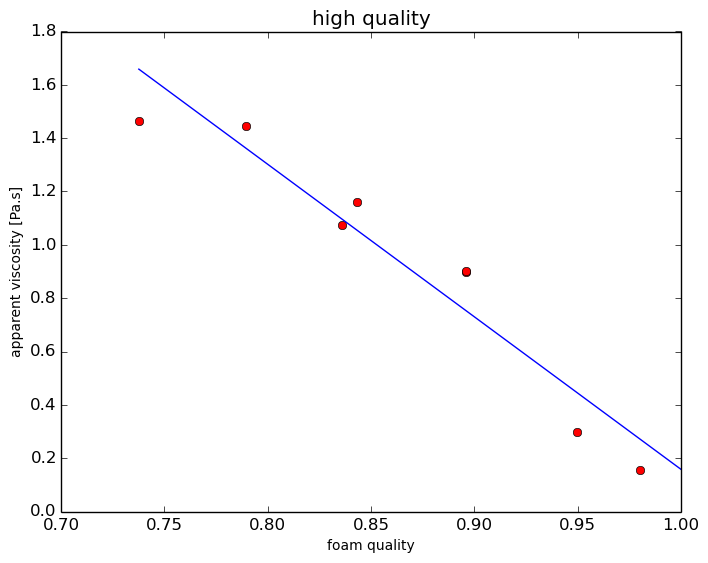

0.1582381434817286

In [19]:
(muf_end,dmudfg)=linreg(fg_high, muf_high)
fg_high_range=linspace(minimum(fg_high), 1.0, 20)
plot(fg_high, muf_high, "or", fg_high_range, dmudfg*fg_high_range+muf_end)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("high quality")
[dmudfg*fg_high_range+muf_end][end]

A negative value is obtained. The fit is not really a fit. I would say at fg=0, we can go with the gas viscosity.

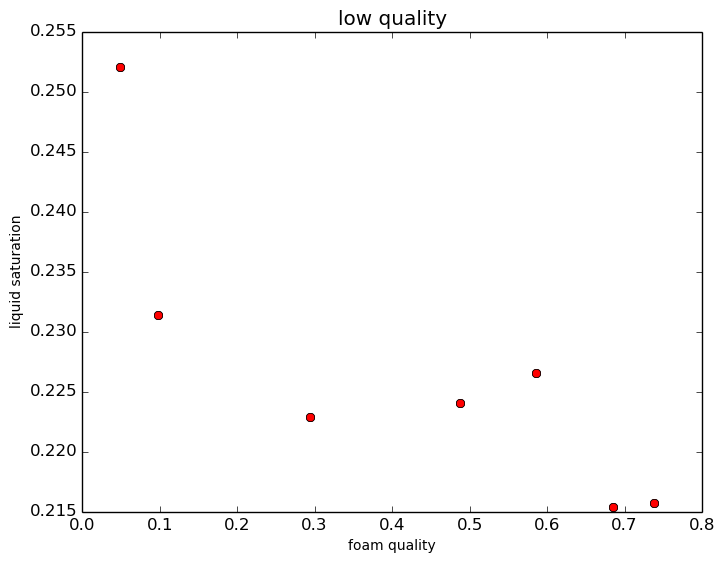

NaN

In [20]:
plot(fg_low, sw_low, "or")
(sw_0,dswdfg)=linreg(fg_low, sw_low)
plot(fg_low, sw_low, "or", fg_low_range, dswdfg*fg_low_range+sw_0)
xlabel("foam quality")
ylabel("liquid saturation")
title("low quality")
sw_0

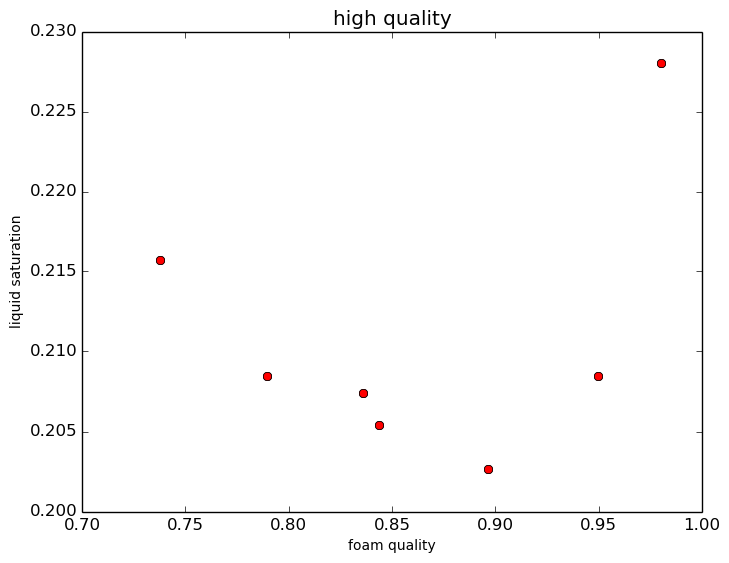

NaN

In [21]:
plot(fg_high, sw_high, "or")
(sw_end,dswdfg)=linreg(fg_high, sw_high)
plot(fg_high, sw_high, "or", fg_high_range, dswdfg*fg_high_range+sw_end)
xlabel("foam quality")
ylabel("liquid saturation")
title("high quality")
[dswdfg*fg_high_range+sw_end][end]

In [22]:
s1=linspace(0,1.0)
plot(s1, muf_0*tanh(1000*s1)+)

LoadError: syntax: unexpected )
while loading In[22], in expression starting on line 2